In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
pd.set_option('use_inf_as_na', True)
from collections import Counter

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import optuna
from optuna.trial import Trial
from functools import partial

# Problem 1

In [94]:
dataset = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/dataset.pkl')
dataset= dataset.drop([x  for x in dataset.columns if 'fqtr' in x],axis=1)
data = dataset[dataset['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)

In [96]:
def f(x):
    if x > 0.05:
        return 1
    elif x < -0.1:
        return -1
    else: 
        return 0

In [97]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

In [98]:
df_train = data.loc['2007-01-01':'2010-01-01'] 
df_valid = data.loc['2010-04-01':'2010-07-01'] 
df_test = data.loc['2010-01-01':'2018-12-31'] # back test

train = df_train.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)
valid = df_valid.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)
test = df_test.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

train_stock_returns = df_train['next_period_return']
valid_stock_returns = df_valid['next_period_return']
test_stock_returns = df_test['next_period_return']

y_train = df_train['rel_performance']
y_valid = df_valid['rel_performance']
y_test = df_test['rel_performance']

y_train = y_train.values
y_valid = y_valid.values
y_test = y_test.values

In [99]:
scaler = StandardScaler()
float_vars = [x for x in train.columns if data[x].dtype == 'float64']

In [100]:
train_norm = train.copy()
valid_norm = valid.copy()
test_norm = test.copy()

In [101]:
train_norm[float_vars] = scaler.fit_transform(train[float_vars])
valid_norm[float_vars] = scaler.transform(valid[float_vars])
test_norm[float_vars] = scaler.transform(test[float_vars])

## Decision Tree Classifier

In [110]:
t_clf0 = DecisionTreeClassifier(max_depth=15,min_samples_leaf=100)
t_clf0.fit(train_norm,y_train)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=100)

In [111]:
def tree_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'feat_imp':m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)

def plot_fi0(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

<AxesSubplot:ylabel='cols'>

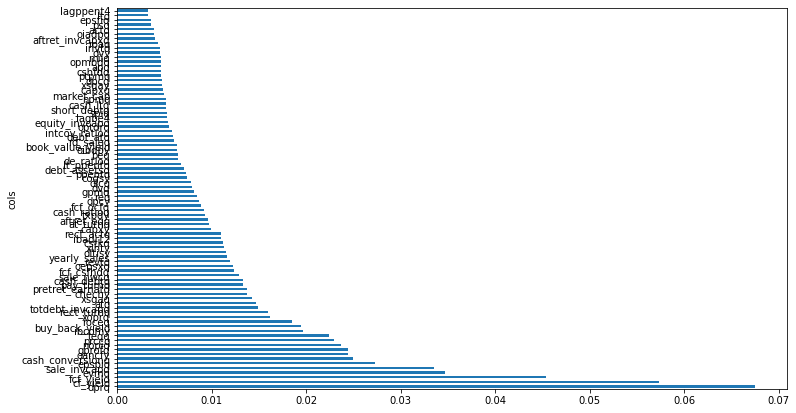

In [112]:
fi0 = tree_feat_importance(t_clf0,train)
features0 = fi0[(fi0['feat_imp'] > 0.0)]

plot_fi0(features0)

In [113]:
len(features0)

82

In [115]:
# accuracy testing
t_clf0.score(train_norm,y_train)
t_clf0.score(valid_norm,y_valid)
pred_value = t_clf0.predict(valid_norm)
profit = (pred_value * valid_stock_returns).sum()
profit

0.5101888667992047

0.3747397640527412

-21.799194000000025

### Use Optuna to find optimal hyperparameters

In [116]:
from functools import partial

In [119]:
def objective0(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    t_min_samples_leaf = trial.suggest_int('min_samples_leaf',100,1200,step=100)
    t_max_depth = trial.suggest_int('max_depth',5,25,step=5)

    
    t_clf = DecisionTreeClassifier(min_samples_leaf = t_min_samples_leaf,max_depth=t_max_depth,random_state=123)
    t_clf.fit(train,labels)

    preds = t_clf.predict(val)
    profit = (preds * val_rets).sum()

    return profit

In [120]:
study = optuna.create_study(direction="maximize")

[I 2024-02-03 12:25:06,053] A new study created in memory with name: no-name-aa43ce73-08d6-4670-8249-4564a2aab45c


In [121]:
%%time
study.optimize(partial(objective0,train=train,labels=y_train,val=valid,
                       val_labels=y_valid,val_rets=valid_stock_returns.values), n_trials=100,n_jobs=-1)

[I 2024-02-03 12:25:10,716] Trial 1 finished with value: -23.72518400000002 and parameters: {'min_samples_leaf': 700, 'max_depth': 20}. Best is trial 1 with value: -23.72518400000002.
[I 2024-02-03 12:25:11,099] Trial 2 finished with value: -23.72518400000002 and parameters: {'min_samples_leaf': 700, 'max_depth': 20}. Best is trial 1 with value: -23.72518400000002.
[I 2024-02-03 12:25:11,228] Trial 3 finished with value: -25.397948000000024 and parameters: {'min_samples_leaf': 600, 'max_depth': 15}. Best is trial 1 with value: -23.72518400000002.
[I 2024-02-03 12:25:12,988] Trial 0 finished with value: -19.19209400000001 and parameters: {'min_samples_leaf': 100, 'max_depth': 15}. Best is trial 0 with value: -19.19209400000001.
[I 2024-02-03 12:25:13,267] Trial 5 finished with value: -42.11555900000003 and parameters: {'min_samples_leaf': 1100, 'max_depth': 5}. Best is trial 0 with value: -19.19209400000001.
[I 2024-02-03 12:25:13,506] Trial 4 finished with value: -34.066232000000035 an

[I 2024-02-03 12:25:46,918] Trial 45 finished with value: -45.05859200000005 and parameters: {'min_samples_leaf': 1200, 'max_depth': 10}. Best is trial 13 with value: -17.595050000000015.
[I 2024-02-03 12:25:47,284] Trial 44 finished with value: -25.397948000000024 and parameters: {'min_samples_leaf': 600, 'max_depth': 10}. Best is trial 13 with value: -17.595050000000015.
[I 2024-02-03 12:25:50,683] Trial 46 finished with value: -17.595050000000015 and parameters: {'min_samples_leaf': 100, 'max_depth': 10}. Best is trial 13 with value: -17.595050000000015.
[I 2024-02-03 12:25:50,755] Trial 47 finished with value: -17.595050000000015 and parameters: {'min_samples_leaf': 100, 'max_depth': 10}. Best is trial 13 with value: -17.595050000000015.
[I 2024-02-03 12:25:50,986] Trial 48 finished with value: -17.595050000000015 and parameters: {'min_samples_leaf': 100, 'max_depth': 10}. Best is trial 13 with value: -17.595050000000015.
[I 2024-02-03 12:25:51,306] Trial 49 finished with value: -1

[I 2024-02-03 12:26:25,971] Trial 88 finished with value: -17.595050000000015 and parameters: {'min_samples_leaf': 100, 'max_depth': 10}. Best is trial 13 with value: -17.595050000000015.
[I 2024-02-03 12:26:26,528] Trial 90 finished with value: -32.53029800000002 and parameters: {'min_samples_leaf': 300, 'max_depth': 10}. Best is trial 13 with value: -17.595050000000015.
[I 2024-02-03 12:26:26,664] Trial 89 finished with value: -17.595050000000015 and parameters: {'min_samples_leaf': 100, 'max_depth': 10}. Best is trial 13 with value: -17.595050000000015.
[I 2024-02-03 12:26:28,500] Trial 91 finished with value: -17.840646000000028 and parameters: {'min_samples_leaf': 200, 'max_depth': 10}. Best is trial 13 with value: -17.595050000000015.
[I 2024-02-03 12:26:29,579] Trial 92 finished with value: -17.840646000000028 and parameters: {'min_samples_leaf': 200, 'max_depth': 10}. Best is trial 13 with value: -17.595050000000015.
[I 2024-02-03 12:26:30,139] Trial 93 finished with value: -17

CPU times: user 4min 49s, sys: 4.23 s, total: 4min 54s
Wall time: 1min 27s


In [122]:
study.best_params

{'min_samples_leaf': 100, 'max_depth': 10}

In [142]:
t_clf1 = DecisionTreeClassifier(**study.best_params,random_state=123)

In [143]:
t_clf1.fit(train,y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=100, random_state=123)

In [144]:
t_clf1.score(train,y_train)
t_clf1.score(valid,y_valid)

0.5027335984095428

0.3927827897293546

In [145]:
fi1 = tree_feat_importance(t_clf1,train)
fi1

,cols,feat_imp
108,dprq,0.073379
105,cf_yield,0.056242
156,fcf_yield,0.040078
95,evmq,0.037746
173,sale_invcapq,0.036467
...,...,...
292,sic_3250,0.000000
293,sic_3260,0.000000
294,sic_3270,0.000000
295,sic_3272,0.000000


In [146]:
features1 = fi1[(fi1['feat_imp'] > 0.00)]

In [147]:
cols = features1['cols'].values
len(cols)

77

In [148]:
cols

array(['dprq', 'cf_yield', 'fcf_yield', 'evmq', 'sale_invcapq', 'epspiq',
       'gprofq', 'buy_back_yield', 'nopiq', 'prccq', 'teqq', 'ibcomy',
       'roceq', 'cash_conversionq', 'efftaxq', 'xoprq', 'oancfy',
       'rect_turnq', 'yearly_sales', 'totdebt_invcapq', 'atq', 'xsgaq',
       'chechy', 'pretret_earnatq', 'pay_turnq', 'cash_debtq',
       'sale_nwcq', 'revtq', 'dltisy', 'xinty', 'rect_actq', 'txpdy',
       'cash_ratioq', 'fcf_ocfq', 'dpcy', 'cshfdq', 'gpmq', 'dvq', 'dlcq',
       'cogsy', 'debt_assetsq', 'lt_ppentq', 'de_ratioq', 'oepsxq',
       'opepsq', 'ibadj12', 'rd_saleq', 'cstkq', 'debt_atq', 'opmadq',
       'intcov_ratioq', 'optdrq', 'capxy', 'lagbe4', 'spiq',
       'short_debtq', 'cash_ltq', 'npmq', 'market_cap', 'capxq', 'xsgay',
       'dpcq', 'ptpmq', 'miiq', 'fcf_csfhdq', 'dvy', 'invtq', 'roaq',
       'at_turnq', 'oiadpq', 'int_totdebtq', 'actq', 'aftret_eqq',
       'epsfiq', 'ltq', 'lagppent4', 'aftret_invcapxq'], dtype=object)

In [168]:
train_red = pd.DataFrame(data = scaler.fit_transform(train[cols].values),columns = cols)
valid_red = pd.DataFrame(data = scaler.transform(valid[cols].values),columns = cols)
test_red = pd.DataFrame(data = scaler.transform(test[cols].values),columns = cols)

In [169]:
t_clf1.fit(train_red,y_train)
valid_1 = valid_red.copy()
valid_1['rets'] = df_valid['next_period_return'].values
train_1 = train_red.copy()
train_1['rets'] = df_train['next_period_return'].values
pred = t_clf1.predict(valid_red)
(pred*valid_1[valid_1.columns[-1]].values).sum()

DecisionTreeClassifier(max_depth=10, min_samples_leaf=100, random_state=123)

-20.136717000000026

### Doing back test for optimal features

In [170]:
start_dates = [pd.to_datetime('2010-01-01') + pd.DateOffset(months = 3 * i) for i in range(21)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]
test_frames = [data.loc[d + pd.DateOffset(months=6):d+pd.DateOffset(months = 9)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]
valid_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
validation_labels = [d['rel_performance'].values for d in test_frames]

In [171]:
scalers = [StandardScaler() for _ in range(len(training_data))]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][cols].values),
                                  columns=cols) for i in range(len(training_data))]
opt_valid_data = [pd.DataFrame(scalers[i].transform(valid_frames[i][cols].values),
                               columns=cols) for i in range(len(valid_data))]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][cols].values),
                              columns=cols) for i in range(len(test_data))]

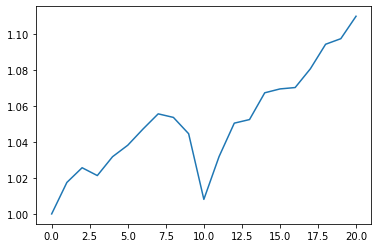

In [172]:
x0 = [1]
ret = []

for i in range(len(start_dates)-1):
        t_clf1.fit(opt_training_data[i],training_labels[i])

        preds = t_clf1.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x0.append(x0[i] + (x0[i]/num_names)*profit_i)
        
plt.plot(x0);

### Compute Shapley values

In [151]:
import shap

In [152]:
def model1(features):
    tree_features = features[features.columns[:-1].values]

    pred = t_clf1.predict(tree_features)

    ret = pred * features[features.columns[-1]]

    return ret

In [153]:
explainer = shap.explainers.Permutation(model1,valid_1,)

In [154]:
shap_values = explainer(valid_1,max_evals=2000,)

PermutationExplainer explainer: 1442it [05:51,  3.99it/s]                       


In [155]:
shap_values.values.shape

(1441, 78)

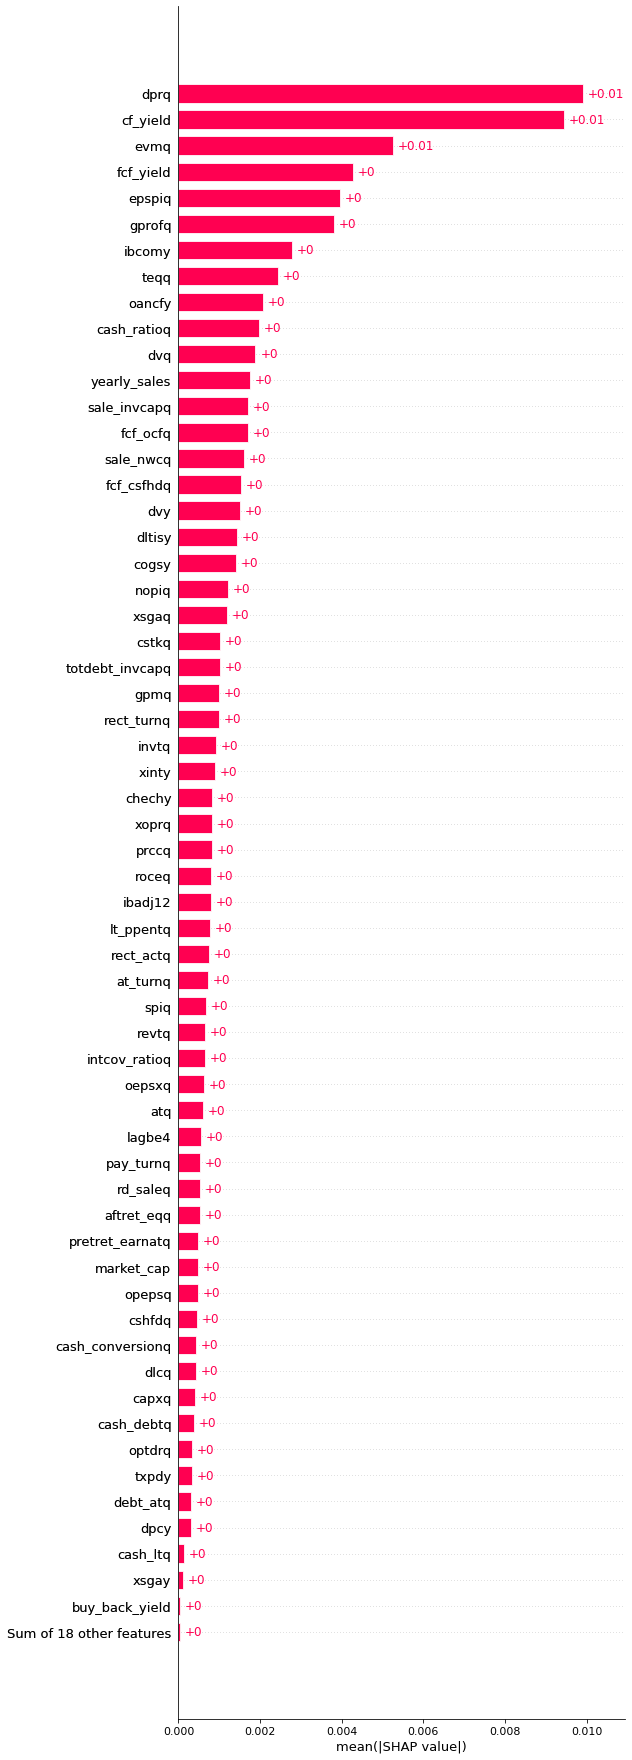

In [156]:
shap.plots.bar(shap_values[:,:-1],max_display=60,)

In [173]:
shap_cols0 = cols[np.abs(shap_values[:,:-1].values).mean(axis=0)>0.000]
shap_cols0

array(['dprq', 'cf_yield', 'fcf_yield', 'evmq', 'sale_invcapq', 'epspiq',
       'gprofq', 'buy_back_yield', 'nopiq', 'prccq', 'teqq', 'ibcomy',
       'roceq', 'cash_conversionq', 'xoprq', 'oancfy', 'rect_turnq',
       'yearly_sales', 'totdebt_invcapq', 'atq', 'xsgaq', 'chechy',
       'pretret_earnatq', 'pay_turnq', 'cash_debtq', 'sale_nwcq', 'revtq',
       'dltisy', 'xinty', 'rect_actq', 'txpdy', 'cash_ratioq', 'fcf_ocfq',
       'dpcy', 'cshfdq', 'gpmq', 'dvq', 'dlcq', 'cogsy', 'lt_ppentq',
       'de_ratioq', 'oepsxq', 'opepsq', 'ibadj12', 'rd_saleq', 'cstkq',
       'debt_atq', 'opmadq', 'intcov_ratioq', 'optdrq', 'capxy', 'lagbe4',
       'spiq', 'cash_ltq', 'market_cap', 'capxq', 'xsgay', 'fcf_csfhdq',
       'dvy', 'invtq', 'at_turnq', 'aftret_eqq', 'epsfiq', 'ltq'],
      dtype=object)

### Doing back test with non-zero shapley values features

In [174]:
start_dates = [pd.to_datetime('2010-01-01') + pd.DateOffset(months = 3 * i) for i in range(21)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]
test_frames = [data.loc[d + pd.DateOffset(months=6):d+pd.DateOffset(months = 9)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]
valid_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
validation_labels = [d['rel_performance'].values for d in test_frames]

In [175]:
scalers = [StandardScaler() for _ in range(len(training_data))]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_cols0].values),
                                  columns=shap_cols0) for i in range(len(training_data))]
opt_valid_data = [pd.DataFrame(scalers[i].transform(valid_frames[i][shap_cols0].values),
                               columns=shap_cols0) for i in range(len(valid_data))]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_cols0].values),
                              columns=shap_cols0) for i in range(len(test_data))]

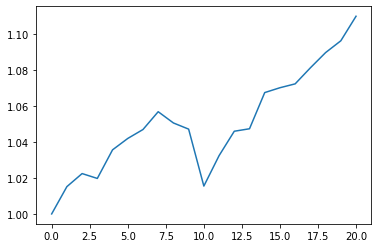

In [176]:
x2 = [1]
ret = []

for i in range(len(start_dates)-1):
        t_clf1.fit(opt_training_data[i],training_labels[i])

        preds = t_clf1.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x2.append(x2[i] + (x2[i]/num_names)*profit_i)
        
plt.plot(x2);

### Computing Sharpe Ratio, Information ratio and alpha for SPY

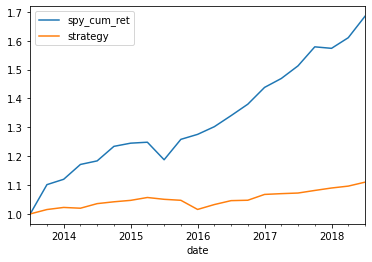

In [177]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/SPY_cum_ret.pkl')
SPY = SPY.loc['2013-07-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0]+1)
SPY['strategy'] = x2

SPY.plot();

In [179]:
print('Sharpe Ratio: ',
      (SPY['strategy'] - 1).diff().mean()/
     (SPY['strategy'] - 1).diff().std())
print('SPY Sharpe Ratio: ',
      (SPY['spy_cum_ret'] - 1).diff().mean()
      /(SPY['spy_cum_ret'] - 1).diff().std())
print('Cumulative Return: ',x2[-1])
print('SPY Cumulative Return: ',SPY['spy_cum_ret'][-1])

Sharpe Ratio:  0.4864495947702829
SPY Sharpe Ratio:  0.9869583355280024
Cumulative Return:  1.1100197763714166
SPY Cumulative Return:  1.6850179999999995


In [180]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]
beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
alpha = np.mean(residual_ret)

print('beta :', beta)
print('Information ratio :', IR)
print('alpha :', alpha)

beta : 0.0983782687485123
Information ratio : 0.20183452979529076
alpha : 0.0021314445734924117


## Bagging Classifier

In [181]:
bg_clf0 = BaggingClassifier(t_clf1,n_estimators=40,random_state=123,n_jobs=-1)
bg_clf0.fit(train_norm,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                        min_samples_leaf=100,
                                                        random_state=123),
                  n_estimators=40, n_jobs=-1, random_state=123)

In [189]:
def bagging_feat_importance(m, df):
    feature_importances = []
    for est in m.estimators_:
        fi = est.feature_importances_
        feature_importances.append(fi)
    feature_importances = np.array(feature_importances)
        
    return pd.DataFrame({'cols':train.columns, 'feat_imp':np.mean(feature_importances,axis=0)}
                       ).sort_values('feat_imp', ascending=False)

def plot_fi2(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

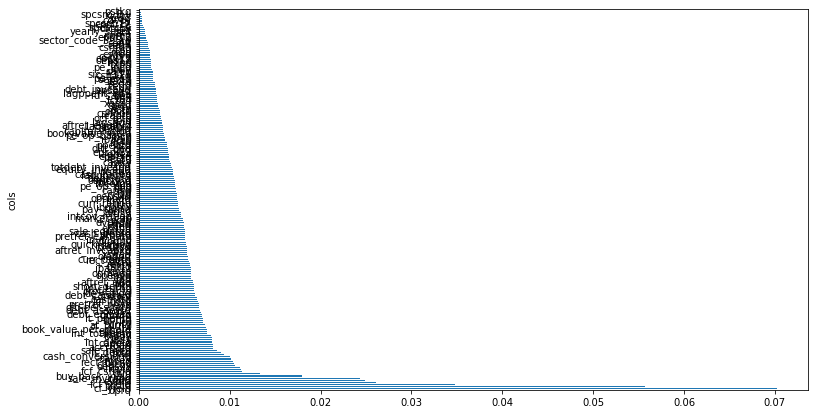

In [190]:
fi2 = bagging_feat_importance(bg_clf0,train)
features2 = fi2[(fi2['feat_imp'] > 0.0)]

plot_fi2(features2);

In [191]:
len(features2)

179

In [192]:
bg_clf0.score(train_norm,y_train)
bg_clf0.score(valid_norm,y_valid)
pred_valid1 = bg_clf0.predict(valid_norm)
profit = (pred_valid1*valid_stock_returns).sum()
profit

0.5447937375745527

0.39902845246356694

-31.49323600000005

### Use optuna to find optimal hyperparameters

In [193]:
def objective1(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    t_min_samples_leaf = trial.suggest_int('min_samples_leaf',100,1200,step=100)
    t_max_depth = trial.suggest_int('max_depth',5,25,step=5)
    t_n_estimators = trial.suggest_int('n_estimators',5,50,step=5)

    
    t_clf = DecisionTreeClassifier(min_samples_leaf = t_min_samples_leaf,max_depth=t_max_depth,random_state=123)
    bg_clf = BaggingClassifier(t_clf,n_estimators=t_n_estimators,random_state=123,n_jobs=1)
    bg_clf.fit(train,labels)

    preds = bg_clf.predict(val)
    profit = (preds * val_rets).sum()

    return profit

In [194]:
study1 = optuna.create_study(direction="maximize")

[I 2024-02-03 15:05:19,821] A new study created in memory with name: no-name-ef138a06-25ea-4895-bad5-9537a5c6f5da


In [195]:
%%time
study1.optimize(partial(objective1,train=train_norm,labels=y_train,val=valid_norm,
                        val_labels=y_valid,val_rets=valid_stock_returns.values), n_trials=200,n_jobs=-1)

[I 2024-02-03 15:06:16,488] Trial 3 finished with value: -38.25400300000004 and parameters: {'min_samples_leaf': 900, 'max_depth': 5, 'n_estimators': 15}. Best is trial 3 with value: -38.25400300000004.
[I 2024-02-03 15:06:29,003] Trial 2 finished with value: -38.97256500000003 and parameters: {'min_samples_leaf': 1100, 'max_depth': 20, 'n_estimators': 30}. Best is trial 3 with value: -38.25400300000004.
[I 2024-02-03 15:06:36,205] Trial 0 finished with value: -37.67379900000003 and parameters: {'min_samples_leaf': 500, 'max_depth': 20, 'n_estimators': 25}. Best is trial 0 with value: -37.67379900000003.
[I 2024-02-03 15:06:44,046] Trial 1 finished with value: -37.69418900000002 and parameters: {'min_samples_leaf': 500, 'max_depth': 20, 'n_estimators': 30}. Best is trial 0 with value: -37.67379900000003.
[I 2024-02-03 15:07:07,384] Trial 6 finished with value: -37.980067000000034 and parameters: {'min_samples_leaf': 900, 'max_depth': 5, 'n_estimators': 20}. Best is trial 0 with value: 

[I 2024-02-03 15:12:40,225] Trial 38 finished with value: -27.459071000000044 and parameters: {'min_samples_leaf': 100, 'max_depth': 25, 'n_estimators': 15}. Best is trial 13 with value: -26.944043000000054.
[I 2024-02-03 15:12:46,063] Trial 39 finished with value: -27.459071000000044 and parameters: {'min_samples_leaf': 100, 'max_depth': 25, 'n_estimators': 15}. Best is trial 13 with value: -26.944043000000054.
[I 2024-02-03 15:12:49,712] Trial 43 finished with value: -30.229178000000037 and parameters: {'min_samples_leaf': 200, 'max_depth': 20, 'n_estimators': 10}. Best is trial 13 with value: -26.944043000000054.
[I 2024-02-03 15:13:00,483] Trial 42 finished with value: -30.706069000000042 and parameters: {'min_samples_leaf': 200, 'max_depth': 20, 'n_estimators': 15}. Best is trial 13 with value: -26.944043000000054.
[I 2024-02-03 15:13:00,994] Trial 46 finished with value: -28.683853000000042 and parameters: {'min_samples_leaf': 200, 'max_depth': 25, 'n_estimators': 5}. Best is tri

[I 2024-02-03 15:18:01,638] Trial 76 finished with value: -30.083948000000028 and parameters: {'min_samples_leaf': 200, 'max_depth': 25, 'n_estimators': 20}. Best is trial 48 with value: -26.843109000000055.
[I 2024-02-03 15:18:07,107] Trial 79 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 15, 'n_estimators': 10}. Best is trial 48 with value: -26.843109000000055.
[I 2024-02-03 15:18:21,665] Trial 83 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 15, 'n_estimators': 10}. Best is trial 48 with value: -26.843109000000055.
[I 2024-02-03 15:18:24,001] Trial 84 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 15, 'n_estimators': 10}. Best is trial 48 with value: -26.843109000000055.
[I 2024-02-03 15:18:38,806] Trial 82 finished with value: -28.77521400000004 and parameters: {'min_samples_leaf': 100, 'max_depth': 15, 'n_estimators': 20}. Best is tri

[I 2024-02-03 15:22:36,754] Trial 122 finished with value: -26.944043000000054 and parameters: {'min_samples_leaf': 100, 'max_depth': 25, 'n_estimators': 5}. Best is trial 48 with value: -26.843109000000055.
[I 2024-02-03 15:22:51,917] Trial 119 finished with value: -27.459071000000044 and parameters: {'min_samples_leaf': 100, 'max_depth': 25, 'n_estimators': 15}. Best is trial 48 with value: -26.843109000000055.
[I 2024-02-03 15:23:01,619] Trial 120 finished with value: -27.459071000000044 and parameters: {'min_samples_leaf': 100, 'max_depth': 25, 'n_estimators': 15}. Best is trial 48 with value: -26.843109000000055.
[I 2024-02-03 15:23:04,070] Trial 123 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 25, 'n_estimators': 10}. Best is trial 48 with value: -26.843109000000055.
[I 2024-02-03 15:23:05,063] Trial 124 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 15, 'n_estimators': 10}. Best i

[I 2024-02-03 15:27:55,945] Trial 161 finished with value: -27.507315000000048 and parameters: {'min_samples_leaf': 100, 'max_depth': 10, 'n_estimators': 5}. Best is trial 128 with value: -26.769035000000052.
[I 2024-02-03 15:27:58,264] Trial 162 finished with value: -27.507315000000048 and parameters: {'min_samples_leaf': 100, 'max_depth': 10, 'n_estimators': 5}. Best is trial 128 with value: -26.769035000000052.
[I 2024-02-03 15:28:04,292] Trial 159 finished with value: -26.769035000000052 and parameters: {'min_samples_leaf': 100, 'max_depth': 10, 'n_estimators': 10}. Best is trial 128 with value: -26.769035000000052.
[I 2024-02-03 15:28:19,051] Trial 163 finished with value: -30.079437000000034 and parameters: {'min_samples_leaf': 200, 'max_depth': 10, 'n_estimators': 10}. Best is trial 128 with value: -26.769035000000052.
[I 2024-02-03 15:28:26,776] Trial 164 finished with value: -26.769035000000052 and parameters: {'min_samples_leaf': 100, 'max_depth': 10, 'n_estimators': 10}. Bes

CPU times: user 1h 23min 11s, sys: 1min 23s, total: 1h 24min 34s
Wall time: 26min 17s


In [196]:
study1.best_params

{'min_samples_leaf': 100, 'max_depth': 10, 'n_estimators': 10}

In [197]:
t_clf2 = DecisionTreeClassifier(**{'min_samples_leaf': 100, 'max_depth': 10},random_state=123)
bg_clf1 = BaggingClassifier(t_clf1,n_estimators=10,random_state=123)

In [198]:
bg_clf1.fit(train_norm,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                        min_samples_leaf=100,
                                                        random_state=123),
                  random_state=123)

In [199]:
bg_clf1.score(train_norm,y_train)

0.532927435387674

In [200]:
bg_clf1.score(valid_norm,y_valid)

0.3983344899375434

In [201]:
pred_valid1 = bg_clf1.predict(valid_norm)
profit = (pred_valid1*valid_stock_returns).sum()
profit

-26.769035000000052

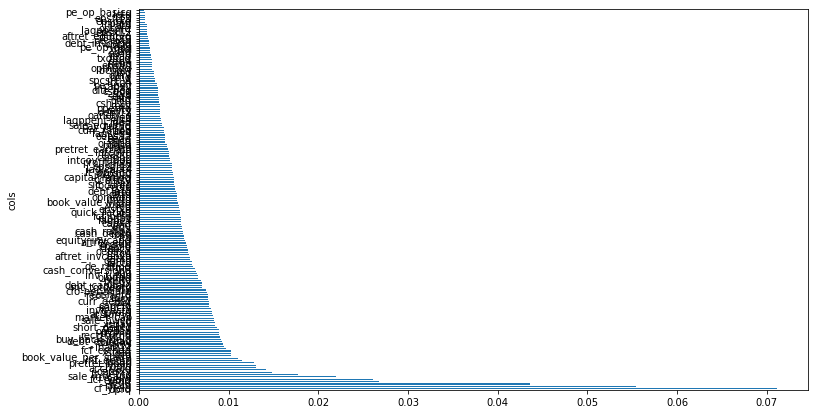

In [202]:
fi3 = bagging_feat_importance(bg_clf1,train_norm)
features = fi3[(fi3['feat_imp'] > 0.0)]

plot_fi2(features);

In [203]:
cols1 = features['cols'].values
float_vars = [x for x in train[cols1].columns if data[x].dtype == 'float64']

In [204]:
train_red_norm = train[cols1].copy()
valid_red_norm = valid[cols1].copy()
test_red_norm = test[cols1].copy()

train_red_norm[float_vars] = scaler.fit_transform((train[cols1])[float_vars])
valid_red_norm[float_vars] = scaler.transform((valid[cols1])[float_vars])
test_red_norm[float_vars] = scaler.transform((test[cols1])[float_vars])

In [205]:
bg_clf1.fit(train_red_norm,y_train)
valid_1_norm = valid_red_norm.copy()
valid_1_norm['rets'] = df_valid['next_period_return'].values

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                        min_samples_leaf=100,
                                                        random_state=123),
                  random_state=123)

### Doing back test for optimal features

In [206]:
start_dates = [pd.to_datetime('2010-01-01') + pd.DateOffset(months = 3 * i) for i in range(21)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]
test_frames = [data.loc[d + pd.DateOffset(months=6):d+pd.DateOffset(months = 9)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]
valid_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
validation_labels = [d['rel_performance'].values for d in test_frames]

In [207]:
scalers = [StandardScaler() for _ in range(len(training_data))]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][cols1].values),
                                  columns=cols1) for i in range(len(training_data))]
opt_valid_data = [pd.DataFrame(scalers[i].transform(valid_frames[i][cols1].values),
                               columns=cols1) for i in range(len(valid_data))]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][cols1].values),
                              columns=cols1) for i in range(len(test_data))]

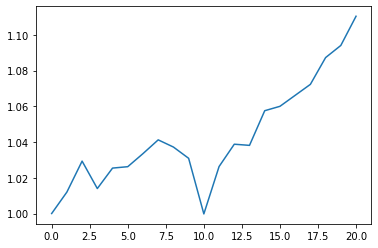

In [208]:
x1 = [1]
ret = []

for i in range(len(start_dates)-1):
        bg_clf1.fit(opt_training_data[i],training_labels[i])

        preds = bg_clf1.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x1.append(x1[i] + (x1[i]/num_names)*profit_i)
        
plt.plot(x1);

### Compute Shapley values

In [209]:
import shap

In [210]:
def model1(features):
    tree_features = features[features.columns[:-1].values]

    pred = bg_clf1.predict(tree_features)

    ret = pred * features[features.columns[-1]]

    return ret

In [211]:
explainer = shap.explainers.Permutation(model1,valid_1_norm,)

In [212]:
shap_values = explainer(valid_1_norm,max_evals=2000,)

PermutationExplainer explainer: 1442it [2:15:35,  5.65s/it]                     


In [213]:
shap_values.values.shape

(1441, 163)

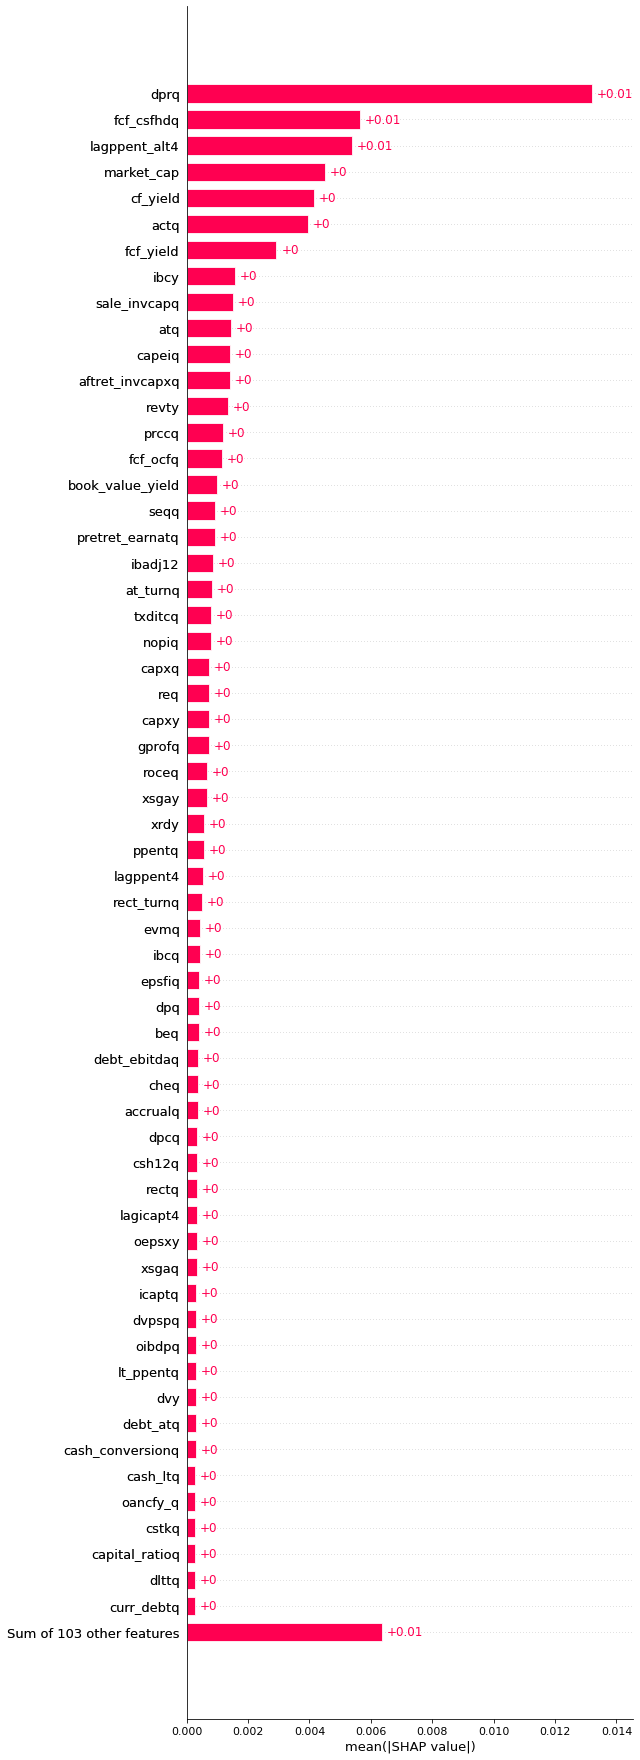

In [214]:
shap.plots.bar(shap_values[:,:-1],max_display=60,)

In [216]:
shap_cols1 = cols1[np.abs(shap_values[:,:-1].values).mean(axis=0)>0.000]
shap_cols1

array(['dprq', 'cf_yield', 'prccq', 'teqq', 'evmq', 'fcf_yield',
       'sale_invcapq', 'lt_debtq', 'oepsxy', 'accrualq', 'nopiq',
       'pretret_noaq', 'roceq', 'int_debtq', 'book_value_per_share',
       'dvq', 'xsgaq', 'fcf_csfhdq', 'ibadj12', 'txtq', 'chechy',
       'debt_ebitdaq', 'buy_back_yield', 'rect_turnq', 'ptpmq', 'opepsq',
       'cogsy', 'short_debtq', 'xsgay', 'niq', 'sale_nwcq', 'market_cap',
       'at_turnq', 'gprofq', 'invt_actq', 'oancfy', 'capeiq', 'dvy',
       'curr_debtq', 'ibcy', 'rect_actq', 'cash_ltq', 'cfo-per-share',
       'int_totdebtq', 'debt_capitalq', 'txpdy', 'oibdpq', 'inv_turnq',
       'apq', 'cash_conversionq', 'cfmq', 'de_ratioq', 'rectq', 'cstkq',
       'aftret_invcapxq', 'cshiq', 'dpcy', 'prcraq', 'aftret_eqq', 'ibcq',
       'cash_debtq', 'cash_ratioq', 'xrdy', 'dpq', 'capxq', 'lagbe4',
       'oibdpy', 'fcf_ocfq', 'quick_ratioq', 'req', 'book_value_yield',
       'invtq', 'dlttq', 'actq', 'debt_atq', 'pcfq', 'ibcomq', 'ocf_lctq',
       'c

### Doing back testing with non-zero shapley values features

In [218]:
start_dates = [pd.to_datetime('2010-01-01') + pd.DateOffset(months = 3 * i) for i in range(21)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]
test_frames = [data.loc[d + pd.DateOffset(months=6):d+pd.DateOffset(months = 9)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]
valid_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
validation_labels = [d['rel_performance'].values for d in test_frames]

In [219]:
scalers = [StandardScaler() for _ in range(len(training_data))]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_cols1].values),
                                  columns=shap_cols1) for i in range(len(training_data))]
opt_valid_data = [pd.DataFrame(scalers[i].transform(valid_frames[i][shap_cols1].values),
                               columns=shap_cols1) for i in range(len(valid_data))]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_cols1].values),
                              columns=shap_cols1) for i in range(len(test_data))]

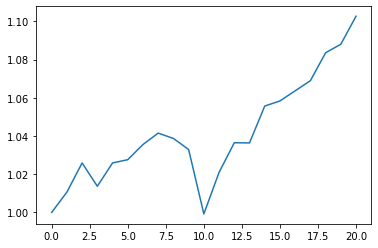

In [220]:
x3 = [1]
ret = []

for i in range(len(start_dates)-1):
        bg_clf1.fit(opt_training_data[i],training_labels[i])

        preds = bg_clf1.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x3.append(x3[i] + (x3[i]/num_names)*profit_i)
        
plt.plot(x3);

### Computing Sharpe Ratio, Information ratio and alpha for SPY

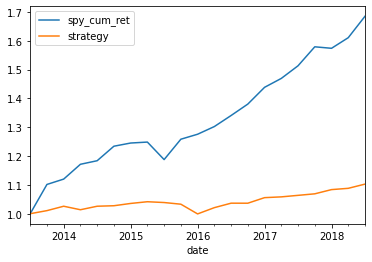

In [221]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/SPY_cum_ret.pkl')
SPY = SPY.loc['2013-07-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0]+1)
SPY['strategy'] = x3

SPY.plot();

In [222]:
print('Sharpe Ratio: ',
      (SPY['strategy'] - 1).diff().mean()/
     (SPY['strategy'] - 1).diff().std())
print('SPY Sharpe Ratio: ',
      (SPY['spy_cum_ret'] - 1).diff().mean()
      /(SPY['spy_cum_ret'] - 1).diff().std())
print('Cumulative Return: ',x3[-1])
print('SPY Cumulative Return: ',SPY['spy_cum_ret'][-1])

Sharpe Ratio:  0.40909897197765366
SPY Sharpe Ratio:  0.9869583355280024
Cumulative Return:  1.1026627502290518
SPY Cumulative Return:  1.6850179999999995


In [223]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]
beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
alpha = np.mean(residual_ret)

print('beta :', beta)
print('Information ratio :', IR)
print('alpha :', alpha)

beta : 0.04019685753778586
Information ratio : 0.3088729479102672
alpha : 0.003756358963611641


## Random Forest

In [255]:
from sklearn.ensemble import RandomForestClassifier

rf_clf0 = RandomForestClassifier(n_estimators=20,
                                    max_depth=15,
                                    min_samples_leaf=1200,
                                    max_features=10)
rf_clf0.fit(train,y_train)

RandomForestClassifier(max_depth=15, max_features=10, min_samples_leaf=1200,
                       n_estimators=20)

In [256]:
def randomforest_feat_importances(m, df):
        
    return pd.DataFrame({'cols':df.columns, 'feat_imp': m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)

def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

<AxesSubplot:ylabel='cols'>

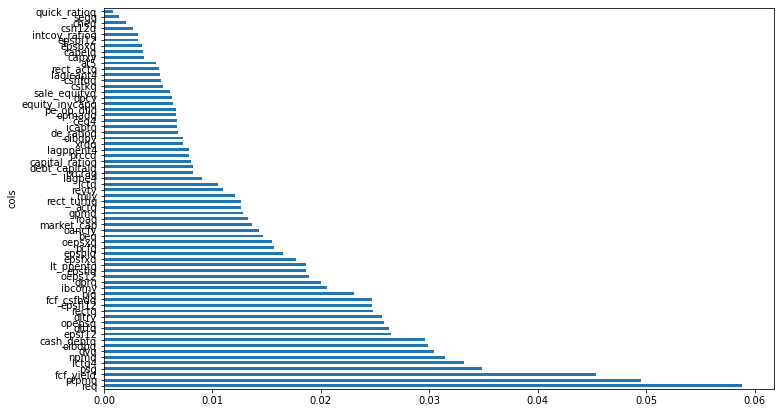

In [257]:
fi4 = randomforest_feat_importances(rf_clf0,train)
features4 = fi4[(fi4['feat_imp'] > 0.0)]

plot_fi(features4)

In [258]:
len(features4)

66

In [259]:
# accuracy testing
rf_clf0.score(train,y_train)
rf_clf0.score(valid,y_valid)
pred_value = rf_clf0.predict(valid)
profit = (pred_value * valid_stock_returns).sum()
profit

0.43054174950298213

0.3802914642609299

-37.04393100000004

### Use Optuna to find optimal hyperparameters

In [260]:
import optuna
from optuna.trial import Trial
optuna.logging.set_verbosity(optuna.logging.FATAL)
import warnings
warnings.filterwarnings("ignore")

In [261]:
def objective(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    rf_n_estimators = trial.suggest_int('n_estimators', 10,40,step=5)
    rf_max_features = trial.suggest_categorical('max_features',['sqrt','log2'])
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf',800,2400,step=800)
    rf_max_depth = trial.suggest_int('max_depth',4,15)
    
    rf_clf = RandomForestClassifier(n_estimators=rf_n_estimators,
                                    max_depth=rf_max_depth,
                                    min_samples_leaf=rf_min_samples_leaf,
                                    max_features=rf_max_features)
    rf_clf.fit(train,labels)
    accuracy = rf_clf.score(val,val_labels)
 
    return accuracy

In [262]:
study = optuna.create_study(direction="maximize")

In [263]:
from functools import partial

In [276]:
%%time
study.optimize(partial(objective,train=train,labels=y_train,val=valid,
                       val_labels=y_valid,val_rets=valid_stock_returns), n_trials=200,n_jobs=-1)

CPU times: user 1min 8s, sys: 21.7 s, total: 1min 29s
Wall time: 41.7 s


In [277]:
study.best_params

{'n_estimators': 10,
 'max_features': 'log2',
 'min_samples_leaf': 1600,
 'max_depth': 13}

In [278]:
rf_clf = RandomForestClassifier(**study.best_params)

In [279]:
rf_clf.fit(train,y_train)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

In [280]:
preds=rf_clf.predict(valid)

In [281]:
valid_profit = (preds * df_valid['next_period_return']).sum()
valid_profit

-40.192237000000034

In [282]:
pred_test=rf_clf.predict(test)

In [283]:
test_profit = (pred_test * df_test['next_period_return']).sum()
test_profit

1426.4615610000003

In [284]:
confusion_matrix(y_test,pred_test)

array([[    0,  2894,  9456],
       [    0, 11416, 21797],
       [    0,  5389, 15628]])

In [285]:
accuracy_score(preds,y_valid)

0.37682165163081194

In [286]:
accuracy_score(pred_test,y_test)

0.40618804445779516

In [287]:
fi = randomforest_feat_importances(rf_clf,train)

In [288]:
features = fi[(fi['feat_imp'] > 0.00)]

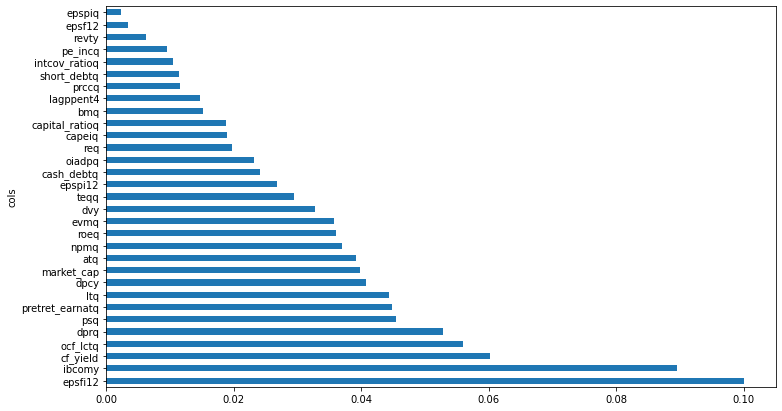

In [289]:
plot_fi(features);

In [290]:
features

,cols,feat_imp
18,epsfi12,0.100000
73,ibcomy,0.089485
105,cf_yield,0.060248
152,ocf_lctq,0.055895
108,dprq,0.052802
101,psq,0.045368
135,pretret_earnatq,0.044816
32,ltq,0.044330
71,dpcy,0.040712
92,market_cap,0.039752


In [291]:
cols = features['cols'].values
float_vars = [x for x in train[cols].columns if data[x].dtype == 'float64']

In [292]:
train_1 = train[features['cols'].values]
valid = valid[features['cols'].values]

In [294]:
rf_clf.fit(train_1,y_train)
rf_clf.score(train_1,y_train)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

0.4364438369781312

In [295]:
pred_valid = rf_clf.predict(valid)
rf_clf.score(valid,y_valid)

0.39208882720333105

In [296]:
(pred_valid * valid_stock_returns).sum()

-37.422818000000035

In [297]:
valid_1 = valid.copy()
valid_1['returns'] = valid_stock_returns.values

### Doing back test for optimal features

In [298]:
start_dates = [pd.to_datetime('2010-01-01') + pd.DateOffset(months = 3 * i) for i in range(21)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]
test_frames = [data.loc[d + pd.DateOffset(months=6):d+pd.DateOffset(months = 9)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]
valid_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
validation_labels = [d['rel_performance'].values for d in test_frames]

In [299]:
from sklearn.preprocessing import StandardScaler

In [300]:
scalers = [StandardScaler() for _ in range(len(training_data))]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][cols].values),
                                  columns=cols) for i in range(len(training_data))]
opt_valid_data = [pd.DataFrame(scalers[i].transform(valid_frames[i][cols].values),
                               columns=cols) for i in range(len(valid_data))]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][cols].values),
                              columns=cols) for i in range(len(test_data))]

In [302]:
x6 = [1]
ret = []

for i in range(len(start_dates)-1):
        rf_clf.fit(opt_training_data[i],training_labels[i])

        preds = rf_clf.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x6.append(x6[i] + (x6[i]/num_names)*profit_i)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

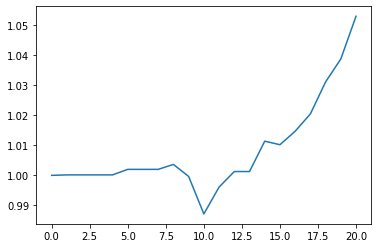

In [304]:
plt.plot(x6)

### Compute Shapley values

In [305]:
import shap

In [306]:
def model(features):
    tree_features = features[features.columns[:-1].values]

    pred = rf_clf.predict(tree_features)

    ret = pred * features[features.columns[-1]]

    return ret

In [307]:
explainer = shap.explainers.Permutation(model,valid_1)

In [308]:
shap_values = explainer(valid_1,max_evals=2000)

PermutationExplainer explainer: 1442it [07:50,  3.00it/s]                       


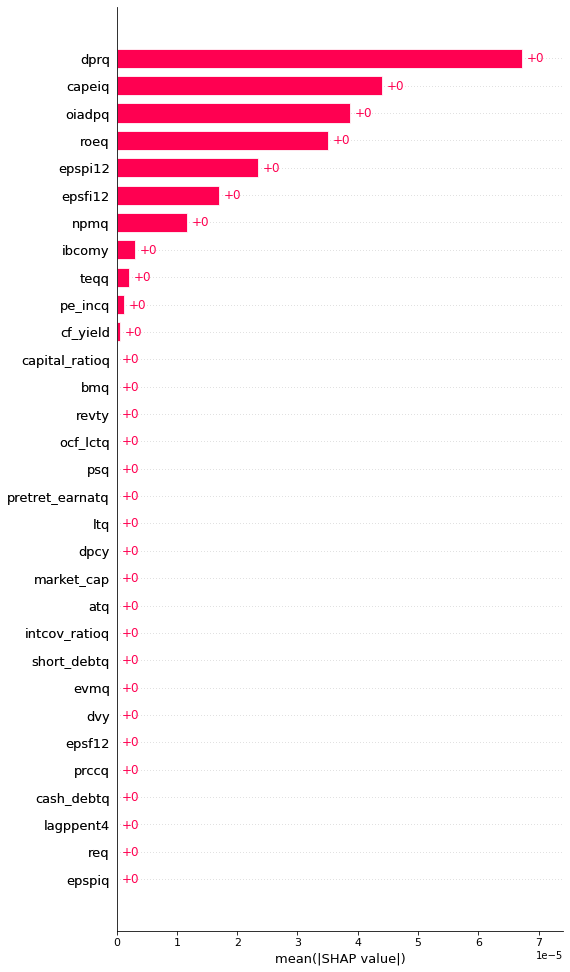

In [309]:
shap.plots.bar(shap_values[:,:-1],max_display=60)

In [310]:
cols = features['cols'].values

In [311]:
shap_cols = cols[np.abs(shap_values[:,:-1].values).mean(axis=0)>0.000]
shap_cols

array(['epsfi12', 'ibcomy', 'cf_yield', 'dprq', 'npmq', 'roeq', 'teqq',
       'epspi12', 'oiadpq', 'capeiq', 'pe_incq'], dtype=object)

### Doing back testing with non-zero shapley values

In [ ]:
start_dates = [pd.to_datetime('2010-01-01') + pd.DateOffset(months = 3 * i) for i in range(21)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]
test_frames = [data.loc[d + pd.DateOffset(months=6):d+pd.DateOffset(months = 9)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]
valid_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
validation_labels = [d['rel_performance'].values for d in test_frames]

In [312]:
from sklearn.preprocessing import StandardScaler

In [313]:
scalers = [StandardScaler() for _ in range(len(training_data))]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_cols].values),
                                  columns=shap_cols) for i in range(len(training_data))]
opt_valid_data = [pd.DataFrame(scalers[i].transform(valid_frames[i][shap_cols].values),
                               columns=shap_cols) for i in range(len(valid_data))]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_cols].values),
                              columns=shap_cols) for i in range(len(test_data))]

In [315]:
x7 = [1]
ret = []

for i in range(len(start_dates)-1):
        rf_clf.fit(opt_training_data[i],training_labels[i])

        preds = rf_clf.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x7.append(x7[i] + (x7[i]/num_names)*profit_i)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=1600,
                       n_estimators=10)

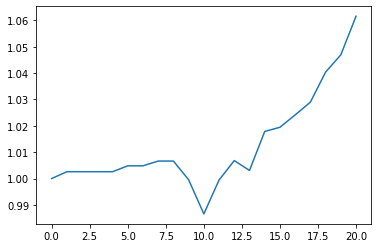

In [317]:
plt.plot(x7);

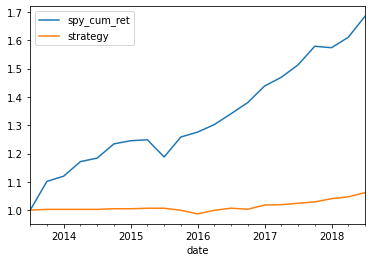

In [318]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/SPY_cum_ret.pkl')
SPY = SPY.loc['2013-07-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0]+1)
SPY['strategy'] = x7

SPY.plot();

In [322]:
print('Sharpe Ratio: ',
      (SPY['strategy'] - 1).diff().mean()/
     (SPY['strategy'] - 1).diff().std())
print('SPY Sharpe Ratio: ',
      (SPY['spy_cum_ret'] - 1).diff().mean()
      /(SPY['spy_cum_ret'] - 1).diff().std())
print('Cumulative Return: ',x7[-1])
print('SPY Cumulative Return: ',SPY['spy_cum_ret'][-1])

Sharpe Ratio:  0.4397412792546729
SPY Sharpe Ratio:  0.9869583355280024
Cumulative Return:  1.0615740284493076
SPY Cumulative Return:  1.6850179999999995


In [323]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]
beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
alpha = np.mean(residual_ret)

print('beta :', beta)
print('Information ratio :', IR)
print('alpha :', alpha)

beta : 0.03348864112268216
Information ratio : 0.28665352518201076
alpha : 0.001931685324236506


# Problem 2

In [225]:
t_clf2 = DecisionTreeClassifier(max_depth=10,min_samples_leaf=100)
bg_clf2 = BaggingClassifier(t_clf2,n_estimators=40,random_state=123,n_jobs=-1)
t_clf2.fit(train_norm,y_train)
bg_clf2.fit(train_norm,y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=100)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                        min_samples_leaf=100),
                  n_estimators=40, n_jobs=-1, random_state=123)

In [226]:
def objective_(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    t_min_samples_leaf = trial.suggest_int('min_samples_leaf',100,1200,step=100)
    t_max_depth = trial.suggest_int('max_depth',5,25,step=5)
    t_n_estimators = trial.suggest_int('n_estimators',5,50,step=5)

    
    t_clf2 = DecisionTreeClassifier(min_samples_leaf = t_min_samples_leaf,max_depth=t_max_depth,random_state=123)
    bg_clf2 = BaggingClassifier(t_clf1,n_estimators=t_n_estimators,random_state=123,n_jobs=1)
    bg_clf2.fit(train,labels)

    preds = bg_clf2.predict(val)
    conviction = bg_clf2.predict_proba(val)[:,2]-bg_clf2.predict_proba(val)[:,0]  
    weights = conviction/abs(conviction).sum()
    profit = (weights * val_rets).sum()

    return profit

In [227]:
study = optuna.create_study(direction="maximize")

[I 2024-02-03 18:25:45,023] A new study created in memory with name: no-name-626b3bb6-837a-4fc1-b7a2-5470281fe425


In [228]:
%%time
study.optimize(partial(objective_,train=train_norm,labels=y_train,
                       val=valid_norm,val_labels=y_valid,val_rets=valid_stock_returns.values),
               n_trials=200,n_jobs=-1)

[I 2024-02-03 18:26:20,118] Trial 0 finished with value: -0.031918910068305495 and parameters: {'min_samples_leaf': 700, 'max_depth': 5, 'n_estimators': 5}. Best is trial 0 with value: -0.031918910068305495.
[I 2024-02-03 18:26:45,374] Trial 3 finished with value: -0.03170754964664991 and parameters: {'min_samples_leaf': 200, 'max_depth': 5, 'n_estimators': 15}. Best is trial 3 with value: -0.03170754964664991.
[I 2024-02-03 18:26:45,509] Trial 1 finished with value: -0.03170754964664991 and parameters: {'min_samples_leaf': 600, 'max_depth': 5, 'n_estimators': 15}. Best is trial 3 with value: -0.03170754964664991.
[I 2024-02-03 18:27:18,608] Trial 4 finished with value: -0.03213743355142336 and parameters: {'min_samples_leaf': 900, 'max_depth': 10, 'n_estimators': 25}. Best is trial 3 with value: -0.03170754964664991.
[I 2024-02-03 18:27:40,481] Trial 2 finished with value: -0.0320054064726976 and parameters: {'min_samples_leaf': 400, 'max_depth': 15, 'n_estimators': 40}. Best is trial

[I 2024-02-03 18:32:58,131] Trial 39 finished with value: -0.031011435812250427 and parameters: {'min_samples_leaf': 500, 'max_depth': 10, 'n_estimators': 10}. Best is trial 20 with value: -0.031011435812250427.
[I 2024-02-03 18:33:20,814] Trial 41 finished with value: -0.03170754964664991 and parameters: {'min_samples_leaf': 700, 'max_depth': 10, 'n_estimators': 15}. Best is trial 20 with value: -0.031011435812250427.
[I 2024-02-03 18:33:31,587] Trial 44 finished with value: -0.031918910068305495 and parameters: {'min_samples_leaf': 200, 'max_depth': 20, 'n_estimators': 5}. Best is trial 20 with value: -0.031011435812250427.
[I 2024-02-03 18:33:41,405] Trial 40 finished with value: -0.03213743355142336 and parameters: {'min_samples_leaf': 500, 'max_depth': 10, 'n_estimators': 25}. Best is trial 20 with value: -0.031011435812250427.
[I 2024-02-03 18:33:50,593] Trial 42 finished with value: -0.03213743355142336 and parameters: {'min_samples_leaf': 700, 'max_depth': 10, 'n_estimators': 2

[I 2024-02-03 18:38:26,618] Trial 80 finished with value: -0.031918910068305495 and parameters: {'min_samples_leaf': 200, 'max_depth': 15, 'n_estimators': 5}. Best is trial 20 with value: -0.031011435812250427.
[I 2024-02-03 18:38:28,525] Trial 77 finished with value: -0.031011435812250427 and parameters: {'min_samples_leaf': 100, 'max_depth': 20, 'n_estimators': 10}. Best is trial 20 with value: -0.031011435812250427.
[I 2024-02-03 18:38:29,630] Trial 78 finished with value: -0.031011435812250427 and parameters: {'min_samples_leaf': 100, 'max_depth': 20, 'n_estimators': 10}. Best is trial 20 with value: -0.031011435812250427.
[I 2024-02-03 18:38:47,384] Trial 81 finished with value: -0.031011435812250427 and parameters: {'min_samples_leaf': 200, 'max_depth': 15, 'n_estimators': 10}. Best is trial 20 with value: -0.031011435812250427.
[I 2024-02-03 18:38:51,580] Trial 84 finished with value: -0.031011435812250427 and parameters: {'min_samples_leaf': 200, 'max_depth': 20, 'n_estimators'

[I 2024-02-03 18:43:08,949] Trial 114 finished with value: -0.031886609789330646 and parameters: {'min_samples_leaf': 400, 'max_depth': 10, 'n_estimators': 35}. Best is trial 20 with value: -0.031011435812250427.
[I 2024-02-03 18:43:18,002] Trial 116 finished with value: -0.031886609789330646 and parameters: {'min_samples_leaf': 600, 'max_depth': 5, 'n_estimators': 35}. Best is trial 20 with value: -0.031011435812250427.
[I 2024-02-03 18:43:19,182] Trial 120 finished with value: -0.031011435812250427 and parameters: {'min_samples_leaf': 300, 'max_depth': 10, 'n_estimators': 10}. Best is trial 20 with value: -0.031011435812250427.
[I 2024-02-03 18:43:19,298] Trial 117 finished with value: -0.031886609789330646 and parameters: {'min_samples_leaf': 500, 'max_depth': 5, 'n_estimators': 35}. Best is trial 20 with value: -0.031011435812250427.
[I 2024-02-03 18:43:43,768] Trial 124 finished with value: -0.031011435812250427 and parameters: {'min_samples_leaf': 100, 'max_depth': 20, 'n_estimat

[I 2024-02-03 18:47:33,382] Trial 157 finished with value: -0.031011435812250427 and parameters: {'min_samples_leaf': 100, 'max_depth': 15, 'n_estimators': 10}. Best is trial 20 with value: -0.031011435812250427.
[I 2024-02-03 18:47:44,858] Trial 158 finished with value: -0.031011435812250427 and parameters: {'min_samples_leaf': 100, 'max_depth': 15, 'n_estimators': 10}. Best is trial 20 with value: -0.031011435812250427.
[I 2024-02-03 18:47:45,337] Trial 159 finished with value: -0.031011435812250427 and parameters: {'min_samples_leaf': 100, 'max_depth': 15, 'n_estimators': 10}. Best is trial 20 with value: -0.031011435812250427.
[I 2024-02-03 18:47:46,247] Trial 156 finished with value: -0.03170754964664991 and parameters: {'min_samples_leaf': 100, 'max_depth': 15, 'n_estimators': 15}. Best is trial 20 with value: -0.031011435812250427.
[I 2024-02-03 18:47:58,371] Trial 162 finished with value: -0.031918910068305495 and parameters: {'min_samples_leaf': 200, 'max_depth': 10, 'n_estima

[I 2024-02-03 18:53:21,896] Trial 195 finished with value: -0.031011435812250427 and parameters: {'min_samples_leaf': 100, 'max_depth': 15, 'n_estimators': 10}. Best is trial 20 with value: -0.031011435812250427.
[I 2024-02-03 18:53:42,460] Trial 196 finished with value: -0.031011435812250427 and parameters: {'min_samples_leaf': 200, 'max_depth': 15, 'n_estimators': 10}. Best is trial 20 with value: -0.031011435812250427.
[I 2024-02-03 18:53:44,200] Trial 198 finished with value: -0.031011435812250427 and parameters: {'min_samples_leaf': 100, 'max_depth': 15, 'n_estimators': 10}. Best is trial 20 with value: -0.031011435812250427.
[I 2024-02-03 18:53:44,322] Trial 197 finished with value: -0.031011435812250427 and parameters: {'min_samples_leaf': 200, 'max_depth': 15, 'n_estimators': 10}. Best is trial 20 with value: -0.031011435812250427.
[I 2024-02-03 18:53:44,721] Trial 199 finished with value: -0.031011435812250427 and parameters: {'min_samples_leaf': 200, 'max_depth': 15, 'n_estim

CPU times: user 1h 36min 11s, sys: 1min 19s, total: 1h 37min 30s
Wall time: 27min 38s


In [229]:
study.best_params

{'min_samples_leaf': 200, 'max_depth': 15, 'n_estimators': 10}

In [230]:
t_clf2 = DecisionTreeClassifier(**{'min_samples_leaf': 200, 'max_depth': 15},random_state=123)
bg_clf2 = BaggingClassifier(t_clf2,n_estimators=10,random_state=123)
t_clf2.fit(train_norm,y_train)
bg_clf2.fit(train_norm,y_train)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=200, random_state=123)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=15,
                                                        min_samples_leaf=200,
                                                        random_state=123),
                  random_state=123)

In [231]:
bg_clf2.score(train_norm,y_train)
bg_clf2.score(valid_norm,y_valid)
pred_valid2 = bg_clf2.predict(valid_norm)
profit2 = (pred_valid2*valid_stock_returns).sum()
profit2

0.49502982107355864

0.39000693962526023

-30.229178000000037

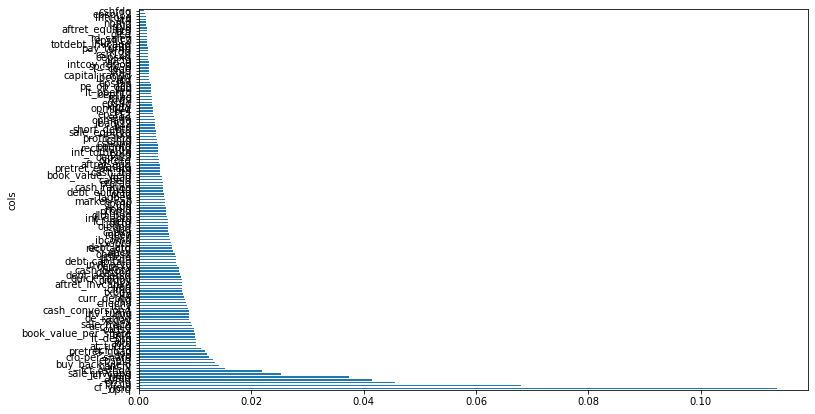

In [232]:
fi2 = bagging_feat_importance(bg_clf2,train_norm)
features2 = fi2[(fi2['feat_imp'] > 0.0)]

plot_fi2(features2);

In [233]:
cols2 = features2['cols'].values
float_vars2 = [x for x in train[cols2].columns if data[x].dtype == 'float64']

In [234]:
train_red_norm2 = train[cols2].copy()
valid_red_norm2 = valid[cols2].copy()
test_red_norm2 = test[cols2].copy()

train_red_norm2[float_vars2] = scaler.fit_transform((train[cols2])[float_vars2])
valid_red_norm2[float_vars2] = scaler.transform((valid[cols2])[float_vars2])
test_red_norm2[float_vars2] = scaler.transform((test[cols2])[float_vars2])

In [235]:
bg_clf2.fit(train_red_norm2,y_train)
valid_2_norm = valid_red_norm2.copy()
valid_2_norm['rets'] = df_valid['next_period_return'].values

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=15,
                                                        min_samples_leaf=200,
                                                        random_state=123),
                  random_state=123)

### Backtest for optimal parameter

In [236]:
scalers = [StandardScaler() for _ in range(len(training_data))]
           
opt_training_data2 = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][cols2].values),
                                   columns=cols2) for i in range(len(training_data))]
opt_valid_data2 = [pd.DataFrame(scalers[i].transform(valid_frames[i][cols2].values),
                                columns=cols2) for i in range(len(valid_data))]
opt_test_data2 = [pd.DataFrame(scalers[i].transform(test_frames[i][cols2].values),
                               columns=cols2) for i in range(len(test_data))]


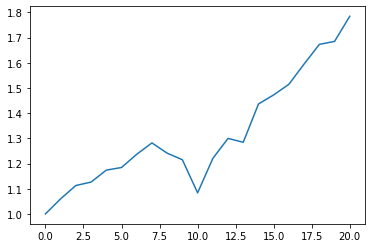

In [237]:
x4 = [1]
ret = []

for i in range(len(start_dates)-1):
        bg_clf2.fit(opt_training_data2[i],training_labels[i])

        preds = bg_clf2.predict(opt_test_data2[i])
        conviction = bg_clf2.predict_proba(opt_test_data2[i])[:,2]-bg_clf2.predict_proba(opt_test_data2[i])[:,0]
        weights = conviction/abs(conviction).sum()
        profit_i = (weights*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        
        x4.append(x4[i] + (x4[i])*profit_i)
plt.plot(x4);

### Shapley values

In [238]:
def model2(features2):
    
    tree_features2 = features2[features2.columns[:-1].values]
    conviction = bg_clf2.predict_proba(tree_features2)[:,2] - bg_clf2.predict_proba(tree_features2)[:,0]
    weight = conviction / abs(conviction).sum()
    ret = weight * features2[features2.columns[-1]]

    return ret

In [239]:
explainer2 = shap.explainers.Permutation(model2,valid_2_norm,)

In [240]:
shap_values2 = explainer2(valid_2_norm,max_evals=2000,)

PermutationExplainer explainer: 1442it [2:55:33,  7.31s/it]                     


In [241]:
shap_values2.values.shape

(1441, 134)

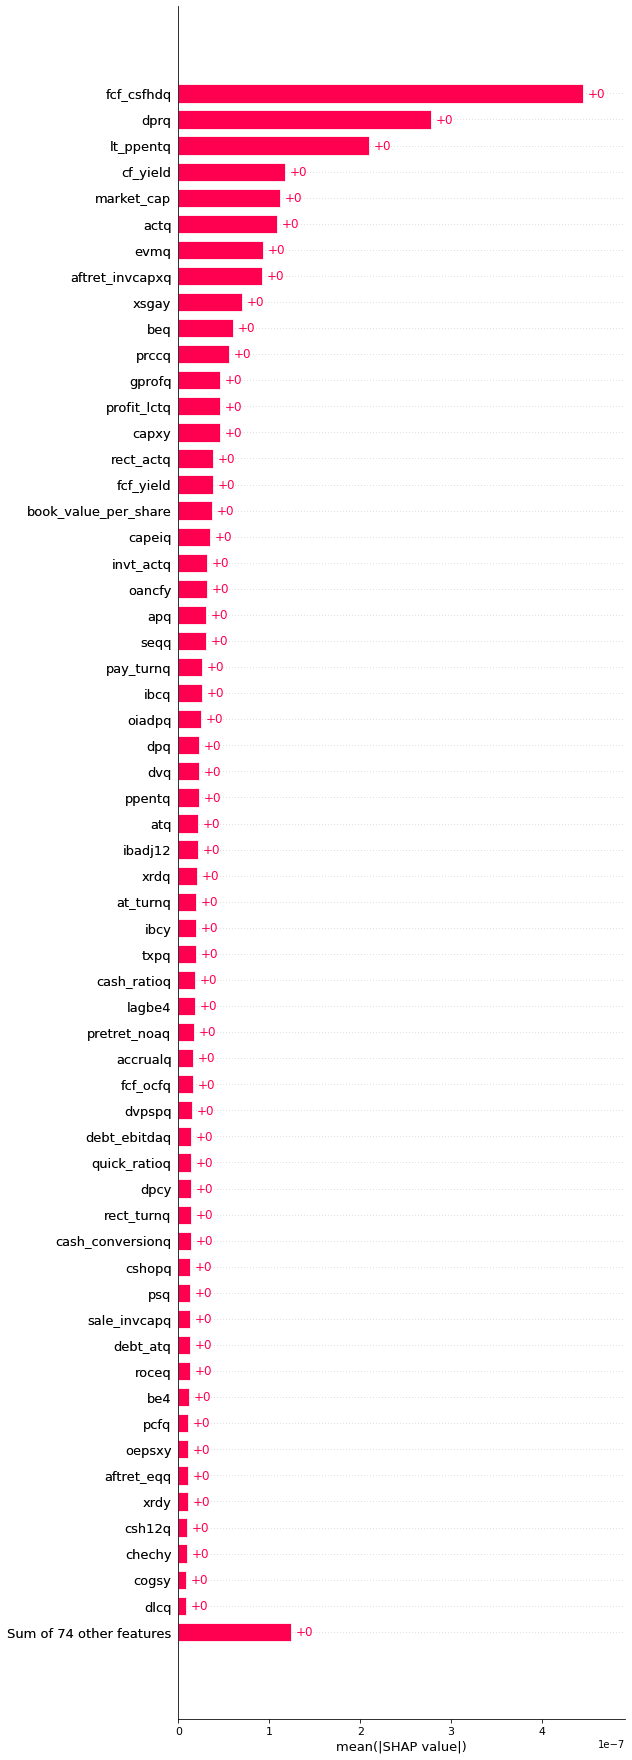

In [242]:
shap.plots.bar(shap_values2[:,:-1],max_display=60,)

In [243]:
shap_cols2 = cols2[np.abs(shap_values2[:,:-1].values).mean(axis=0)>0.000]
shap_cols2

array(['dprq', 'cf_yield', 'prccq', 'evmq', 'teqq', 'fcf_yield',
       'sale_invcapq', 'fcf_csfhdq', 'oancfy', 'buy_back_yield', 'epspiq',
       'cfo-per-share', 'dvq', 'pretret_noaq', 'ocf_lctq', 'at_turnq',
       'actq', 'apq', 'lt_debtq', 'txtq', 'book_value_per_share', 'cogsy',
       'accrualq', 'sale_nwcq', 'xsgay', 'dvy', 'cash_conversionq',
       'ibcy', 'chechy', 'niq', 'curr_debtq', 'ltq', 'txpdy', 'req',
       'aftret_invcapxq', 'oibdpy', 'quick_ratioq', 'debt_assetsq',
       'dvpspq', 'cash_debtq', 'oepsxy', 'invt_actq', 'debt_capitalq',
       'gprofq', 'dpcy', 'rect_actq', 'debt_atq', 'xoprq', 'ibcq',
       'roceq', 'capxy', 'dpq', 'oibdpq', 'fcf_ocfq', 'int_debtq',
       'dltt_beq', 'ptpmq', 'nopiq', 'market_cap', 'lagbe4', 'pcfq',
       'debt_ebitdaq', 'cash_ratioq', 'capeiq', 'roaq',
       'book_value_yield', 'cash_ltq', 'oiadpq', 'aftret_eqq', 'txpq',
       'int_totdebtq', 'rect_turnq', 'ppentq', 'cshopq', 'profit_lctq',
       'cstkq', 'sale_equityq', 'beq

### Back test for non-zero sharpley features

In [244]:
scalers = [StandardScaler() for _ in range(len(training_data))]
           
opt_training_data2 = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_cols2].values),
                                   columns=shap_cols2) for i in range(len(training_data))]
opt_valid_data2 = [pd.DataFrame(scalers[i].transform(valid_frames[i][shap_cols2].values),
                                columns=shap_cols2) for i in range(len(valid_data))]
opt_test_data2 = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_cols2].values),
                               columns=shap_cols2) for i in range(len(test_data))]

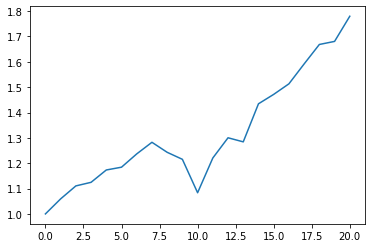

In [245]:
x5 = [1]
ret2 = []

for i in range(len(start_dates)-1):
        bg_clf2.fit(opt_training_data2[i],training_labels[i])

        preds = bg_clf2.predict(opt_test_data2[i])
        conviction = bg_clf2.predict_proba(opt_test_data2[i])[:,2]-bg_clf2.predict_proba(opt_test_data2[i])[:,0]
        weights = conviction/abs(conviction).sum()
        profit_i = (weights*test_frames[i]['next_period_return']).sum()
        ret2.append(profit_i)
        
        x5.append(x5[i] + (x5[i])*profit_i)
        
plt.plot(x5);

### Computing Sharpe Ratio, Information ratio and alpha for SPY

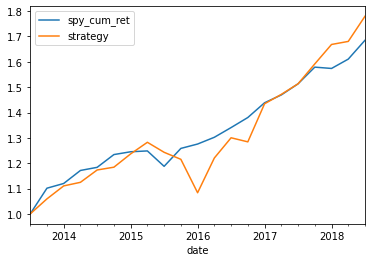

In [251]:
SPY = pd.read_pickle(r'/Users/jinnan2/Desktop/uchi course/FInM/SPY_cum_ret.pkl')
SPY = SPY.loc['2013-07-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0]+1)
SPY['strategy'] = x5

SPY.plot();

In [252]:
print('Sharpe Ratio: ',
      (SPY['strategy'] - 1).diff().mean()/
     (SPY['strategy'] - 1).diff().std())
print('SPY Sharpe Ratio: ',
      (SPY['spy_cum_ret'] - 1).diff().mean()
      /(SPY['spy_cum_ret'] - 1).diff().std())
print('Cumulative Return: ',x5[-1])
print('SPY Cumulative Return: ',SPY['spy_cum_ret'][-1])

Sharpe Ratio:  0.616070756534396
SPY Sharpe Ratio:  0.9869583355280024
Cumulative Return:  1.7797598853050525
SPY Cumulative Return:  1.6850179999999995


In [253]:
strategy_ret2 = (SPY['strategy'] - 1).diff().values[1:]
spy_ret2 = (SPY['spy_cum_ret'] - 1).diff().values[1:]
beta2 = (np.cov(spy_ret2,strategy_ret2)/np.var(spy_ret2))[1,0]
residual_ret2 = strategy_ret2 - beta2 * spy_ret2
IR2 = np.mean(residual_ret2)/np.std(residual_ret2)
alpha2 = np.mean(residual_ret2)

print('beta :', beta2)
print('Information ratio :', IR2)
print('alpha :', alpha2)

beta : 0.5246949690725193
Information ratio : 0.35417381862062886
alpha : 0.02101671934904668
